<a href="https://colab.research.google.com/github/KillianCa/CS4287-Project2/blob/main/CS4287_Prj2_21332673.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Student name and ID:**

Killian Carty - 21332673


**Excecution of Code:**

Code executes till end without error.


**Third Party Implementations:**

This DQN was implemented using the code using the following

CS4387 lab 9 - https://learn.ul.ie/d2l/le/lessons/45660/topics/846685

CS4387 lecture P - https://learn.ul.ie/d2l/le/lessons/45660/topics/809573

Gym Enviornment Mountain Car - https://www.gymlibrary.dev/environments/classic_control/mountain_car/

link to github repository where mountain car problem is solved - https://github.com/adibyte95/Mountain_car-OpenAI-GYM

**Note Book Structure:**

The note book follows the following structure.

*   List of third part sources
*   Code implementation with comments and texts blocks
*   Why reinforcement learning
*   The gym environment
*   Implementation
*   Results
*   Results evaluation
*   Full code with no comments or text blocks in a single code block




# Code Implementation With Comments And Text Blocks

Importing the necessary libraries needed to complete the assignment

In [ ]:
#To provide ways to create random numbers to use for implementation
import random
#To create the enviornment for reinforcement learning for mountain car
import gym
#For maths calculations
import numpy as np
#Used to build and implement the DQN
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#Used to create plots and visulisations
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


Adding a random seed to ensure reproducibility during testing and debugging as the training process is consistent across runs

In [ ]:
#defining a random seed number ( can be any value )
SEED = 40
#setting this seed for random library
random.seed(SEED)
#setting this seed for numpy library
np.random.seed(SEED)
#setting this seed for tensorflow library
tf.random.set_seed(SEED)

Defining the constant hyper parameters

In [ ]:
#Total number of training episodes
EPOCHS = 1000
# The threshold defines what is classified as solving the problem.
# In mountain car if the average reward is greater than or equal to -110
# over 100 episodes that is considered a success
THRESHOLD = -110
#Number of samples used for training in each replay step
BATCH_SIZE = 64

Defining teh DQN class that will create the network and define all the methods we will use to solve the problem

In [ ]:
class DQN:
  #Constructor takes the name of the gym enviornment with is mountain car as "env_string".
  #Number of experinces sampled for training is "batch_size"
  def __init__(self, env_string, batch_size=BATCH_SIZE):
    #Creating memory buffer for storing experinces limiting the meory to 100000 most recent experinces
    self.memory = deque(maxlen=100000)
    #Loading the gym environment
    self.env = gym.make(env_string)
    #Input size set to number of values for the state which is 2 for mountaincar
    #Cars position and cars velocity
    input_size = self.env.observation_space.shape[0]
    #Actions size is set to number of possible actions in enviormnet which is 3 for mountain car
    #push left, do nothing, push right
    action_size = self.env.action_space.n
    #NUmber of experinces per training batch
    self.batch_size = batch_size
    #discount factor for future rewards, which encourages long term rewrads ober short term
    self.gamma = 0.99
    #This is the exploration rate, probabality of random actioons
    self.epsilon = 1.0
    #The minimum exploration rate
    self.epsilon_min = 0.01
    #rate the exploration rate is reduced ensureing behavior gradually shifts from exploration
    #to exploitation (however it will never decay below epsilon_min)
    self.epsilon_decay = 0.995
    #this is the learning rate for the network
    self.alpha = 0.01

    #Creating the network structure
    #intialiseing the model as sequential
    self.model = Sequential()
    #Adding first layer to model. Fully connected with 24 neurons setting input_size to number of state values
    #which is 2 for mountain car
    #using relu as activation introducing non linearity and reducing vanishing gradient issues
    self.model.add(Dense(24, input_dim=input_size, activation='relu'))
    #Adding second layer to model. Fully connected with 24 neurons.
    #Using relu as activation introducing non linearity and reducing vanishing gradient issues
    self.model.add(Dense(24, activation = "relu"))
    #Adding final putput layer. number of neurons is set to action_size which is the number of possible actions in enviornment
    #which is 3 for mountain car
    #Activation function is linear meaning no function applied
    self.model.add(Dense(action_size, activation = "linear"))
    #compiling the model using adam optimizer and learning rate set to alpha and loss is set to mean square error
    self.model.compile(loss = "mse", optimizer = Adam(learning_rate = self.alpha))

  #The remeber method stores experiences during its interaction with enviornment
  def remember(self, state, action, reward, next_state, done):
    #experinece is added with the following: state is set to mountain car envoirnment current state with position and velocity
    #action stores the action taken by the agent
    #reward stores the reward recieved for taking that action
    #next_state stores the resulting state of the enviornmnet after taking the action
    #done stores true or false depending if the episode has finshed or not
    self.memory.append((state, action, reward, next_state, done))

  #This method selects the action the agent will take
  def choose_action(self, state):
    #generate a random number and if it is less than or equal to the exploration rate a random action is taken
    if np.random.rand() <= self.epsilon:
      #returning the random action that has been selected
      return self.env.action_space.sample()
    #if random number is greater than exploration rate we predict all q values for all possible actions
    #verbose = 0 gets rid of unneeded outputs
    q_values = self.model.predict(state, verbose = 0)
    #we return the action with the highest q value
    return np.argmax(q_values[0])

  #function to reshape input to match that requierd by network
  #state is a 1D array of [position, velocity]
  #we reshape it into 2D array for the network
  def preprocess_state(self, state):
    return np.reshape(state, [1, self.env.observation_space.shape[0]])

  #Method that will be used in training method that uses past experinces to train model
  def replay(self):
     # We check that memory has enough values to generate a sample of batch size, if not we skip the replay method
    if len(self.memory) < self.batch_size:
        return
    #mini batch is a batch of randomly selected experineces from memory
    minibatch = random.sample(self.memory, self.batch_size)
    #for each experinece in the minibatch we do the following
    for state, action, reward, next_state, done in minibatch:
      #target is set to either
      #the reward if done is set to true meaning the episode has finished
      #if the episode is not finished target is set to reward + (discount factor * the max q-value for next state)
      target = reward if done else reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])
      #Q values are adjusted usinng the target, updating the action that was taken
      target_f = self.model.predict(state, verbose=0)
      target_f[0][action] = target
      #We then train the network wityh the new q values
      self.model.fit(state, target_f, epochs=1, verbose=0)
      #exploration rate is updated gradually reducing exploration
      if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def train(self):
    #variable scores created to keep track of last 100 episodes which we use to measure preformance
    scores = deque(maxlen=100)
    #avg_scores stores the avrafe scores over the episodes which we compare with threshold to determine success
    avg_scores = []
    #loop going through each episode in the range epochs which is 1000
    for e in range(EPOCHS):
      #reseting the enviornment ensuring each episode begins in intial state
      state = self.env.reset()
      #reshaping state into shape required by network
      state = self.preprocess_state(state)
      #done inidacates if the episode has finished or not
      done = False
      #i measures the total score over the entire episode
      i = 0
      #creating a while loop that runs while done is false, the agent interacts with
      #the enviornment inside this loop until either they reach the end of the episode or the mean
      #score exceeds the threshold
      while not done:
        #The agent selects an action based on the choose action function we defined
        action = self.choose_action(state)
        #the action selected is exectuded and we store the results
        next_state, reward, done, _ = self.env.step(action)
        #we reshape the next state into the shape required by the network
        next_state = self.preprocess_state(next_state)
        # We set the rewards:
        #The reward is set to the car's position (next_state[0][0]).
        #This provides feedback to encourage progress toward the goal. The closer to the goal the more positive the cars position is.
        #for example -1.2 is the position furthest away from the goal and the number increases as the car approaches the goal encouraging the agent
        #to prioratise actions that move towards the goal
        #If the episode is done:
        #If the car's position is less than 0.5, the agent has not reached its goal, and the reward remains unchanged.
        #If the car's position is greater than or equal to 0.5, the agent is rewarded with 100,
        #providing a strong incentive for reaching the goal.
        reward = next_state[0][0]
        if done and next_state[0][0] >= 0.5:
          reward = 100
        #we save the experince using the remember method so it can be used for training
        self.remember(state, action, reward, next_state, done)
        #we then update the state to match the new state after the action
        state = next_state
         #adding the new reward to the total reward
        i += reward

      #once the episode ends and we leave the while loop we add the episodes total reward to score
      scores.append(i)
      #update the average score
      avg_score = np.mean(scores)
      #we then append this new avrage to the list of averages
      avg_scores.append(avg_score)

      #We now check is the avr_score exceeds the threshold and we are past the 100th episode returning the average scores if we do
      if avg_score >= THRESHOLD and e >= 100:
        print("Ran {} episodes. Solved after {} trials".format(e, e))
        return avg_scores

      #we print the episode number and avrage reward to get feedback during training
      if e % 20 == 0:
        print("[Episode {}] - Mean survival time over last 100 episodes: {} ticks.".format(e, avg_score))
        print("Episode {}: Total Reward = {}".format(e, i))

      #we call the replay function so the model learns from the new experineces
      self.replay()

    #if we reach this point it means the agent went tghrough all episodes and could not solve problem
    #we print tyhis info to the console and return the avrage scores
    print('Did not solve after {} episodes ðŸ ̃ž'.format(e))
    return avg_score




Main script where the agent attemps to solve mountain car problem

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_check

[Episode 0] - Mean survival time over last 100 episodes: -105.13361892104149 ticks.
Episode 0: Total Reward = -105.13361892104149
[Episode 20] - Mean survival time over last 100 episodes: -103.71663105203992 ticks.
Episode 20: Total Reward = -74.85541316866875
[Episode 40] - Mean survival time over last 100 episodes: -103.20413142733457 ticks.
Episode 40: Total Reward = -105.19155666232109
[Episode 60] - Mean survival time over last 100 episodes: -99.17914551814071 ticks.
Episode 60: Total Reward = -133.34363359212875
[Episode 80] - Mean survival time over last 100 episodes: -94.85522612248674 ticks.
Episode 80: Total Reward = -85.80018183588982
Ran 100 episodes. Solved after 100 trials


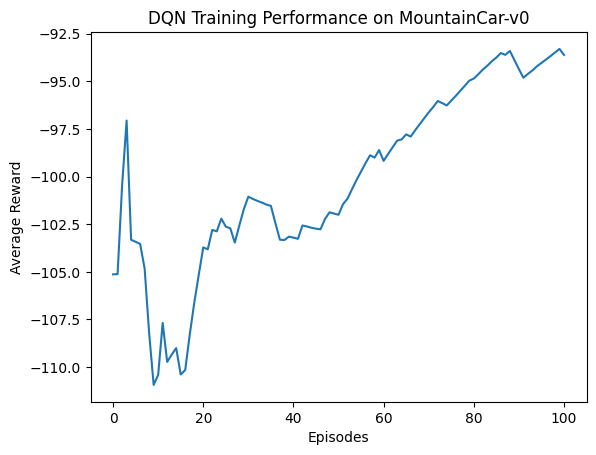

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              75 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,243 (8.77 KB)

 Trainable params: 747 (2.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,496 (5.85 KB)

In [ ]:
#set variable env_string to mountain car which we will pass to the DQN class constructor
env_string = "MountainCar-v0"
#agent is set to instance of DQN class
agent = DQN(env_string)
#we train the agent and return the avrage scores
avg_scores = agent.train()

#We plot the results of of the training process number of episodes compared to reward
plt.plot(avg_scores)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('DQN Training Performance on MountainCar-v0')
plt.show()

#print summary of the network used by the dqn agent
agent.model.summary()

#Why Reinforcement Learning:
**Attributes of Reinforcement Learning:**The mountain car problem involes interacting with an enviroment taking various actions in ceratin states to advance to a new state, attempting to maximize a long term reward. This type of problem is perfect for reinforcement learning as RL is designed to solve problems by learning an optimal solution to maximize a long term reward. By using reinformcement learning we can train an agent to select the correct actions in certain states to maximize the overall reward and solve the problem.

**Issues using other types of learning:**Since there are no clear explicit lables for the mountain car problem, the use of supervised learning is not possible as there are no input/output pairs for the model to train on to learn patters. Unsupervised learning is also not optimal as mountain car is a goal driven problem where the agent wants to maximize a reward. Unsupervised learning does not take this goal driven approach into account. Unsupervised learning mainly tries to identify patters in data not determining what actions to take to maximize an output.


#The Gym Environment:
The gym environment is vital for completing this task. The gym environment is an open source libarary from OpenAI that allows you to test and develop reinforcement learning agents. In the above code we use the "MountainCar-v0" gym environment. The goal of mountain car is to move a car up a steep hill to the goal flag. The gym environment defines the state space, action space and state transitioning for the mountain car problem.
*  State space: The state space represents the current state of the car based on its position and velocity.
*  Action Space: The action space describes the 3 actions that can be taken by the agent. Which are go left, go right, do nothing.
*  Transitioning: The gym environment also handles the transitioning from one state to another based on the action by updating the cars position and velocity based on the action taken.

 The gym environment also has a predefined reward system for the problem which is a reward of -1 given for each time step until the car reaches the goal. This -1 per step penalises the agent for taking to long and encourages it to find actions that lead it closer to the goal. This reward system had to be altered in the above code as it was penalising the agent too harshly and it never improved. Intial tests using the defualt reward showed the agent was stuck at an overall reward of -200 which is the worst overall reward in the default system as it means the episode ran for the maximum 200 steps and the agent recieved a -1 reward for each step. The reward system was updated to use the cars position as the reward system as the further the car is away from the goal the smaller the number that represents its position is. This meant that the agent associates being closer to the goal with a higher reward. The default system could be used however the number of epochs would need to be increased as the agent will only improve if it stumbles apon the goal state accidently using trail and error. The gym enviorment also gives useful functions such as "reset()" that allow us to reset the environment before the next episode. The overall roll of the gym environment is to provide the agent with the sates actions and enviornment of the problem allowing the agent to play the game and learn an optimal solution.

![Image representation of mountain car problem](https://drive.google.com/uc?id=1C4rb0x1znYhX_rkH7FZsnD6k7gS93SpT)

(Image representation of mountain car problem)

#Implementation:
**Capture and Sampling of Data:**
The data used for training and learning is captured in the "remember()" method in the "DQN" class. It stores the agents experinces as a tuple of (state, action, reward, next_state, done):
*  state: The current state of the environment
*  action: The action selected by the agent.
*  reward: The reward revived for taking the action.
*  next_state: The new state after the action.
*  done: A boolean value indicating if the episode is done or not.

Each experience is stored in a deque memory buffer of max size 100,000. Oldest experinces are replaced by new ones if the buffer limit is reached

The data from the buffer is sampled in the replay method creating a mini batch of size 64 which randomly selects from the memory buffer.

**Network Structure:**
The code uses a deep Q-network to solve the problem. It consists of 3 layers: Input, Hidden and Output. The input layer has 24 neurons and uses the relu activation function. The hidden layer also has 24 layers with relu activation function. The relu function is used to avoid issues such as vanishing gradients. The output layer has 3 neurons which corrisonds to the 3 possible actions the agent can take, this layer uses a linear activation function so the values arent changed. The network uses the mean squared error loss function, which calculates the average squared to update the weights with an adam optimizer that has a learning rate of 0.01.

**Where Learning Update is Applied:**
The Q learning and error calculation take place in the replay method. The Q-values are updated based on the bellman equation. For each experinece if the episode is done the taget q-value for the action is set to the reward as there will be no future actions in the episode. If the episode is not done the target q-value is updated to the reward for the action + the discount factor for future rewards multiplied by the maximum predicted q-value for the next state. The predicted q-values for the current state are then preidicted by the network and we update the q-value for the action taken using the target q-value. We then train the network with the new q-values. The network learns and calculates the error using the mean squared error which compares the q-values outputted by the network to the target q-values calculates the difference between the 2 values and this is used to update the weights.

**Random Seed Intialisation:**
Setting a random seed ensures reproducibility meaning the trainning process will be consistent across runs. We use random seed of 1671 which is used as the seed for all the random methods. This helps for debugging and comparing results as the training is consistent across different runs.

**Impact of Regularisers:**
While not implemented in the code regularization methods could be implemented to prevent overfitting, where the model learns the training data too well and preforms poorly on unseen data. Using technequies such as drop out, which turns off some neurons during training, ensures the network does not rely too heavily on certain neurons or L2 regularization, where a weight decay is introduced to penalize large weights in the network. Techniques like these could be added to help the agent preform better on unseen data.

**Counters for Catastropic Forgetting:**
Catastrophic forgetting is an issue where during training the agent forgets previously learned information while it learns new information. The use of a large buffer containing a number of different expiernces and then randomly sampling this buffer acts as a measure to counter catestrophic forgetting. Given that the buffer is sampled randomly both old and new experinces can be sampled ensuring the network does not forget earlier experinces as new ones are learned

#Results:



![Image representation of mountain car problem](https://drive.google.com/uc?id=1NGdGbHnLgG62tgHbQZ2xGnfw1VeA-Skd)

The problem requires an agent in order to both balance exploration and eploitation effectively. The agent takes actions in different stages during exectuion to maximise the cumulative rewards. This task is ideal when it comes to Deep Q-learning and it can apporixamte the Q-values and learn what is the optimal policy to employ with the use of experience recollection.


**Challenges:**
While the agent proves the ability of being able to improve it's performance of episodes, initaially the reward is fairly low due the agent's exploration. As the epsilon decays, the agent starts to transition to more of an exploitation based method. This method is done by selecting the learned Q-values which overall does lead to better rewards. Even though at some moments of time the agent achieves higher rewards, there are many oscillations of varying performance.

#Evaluation of Results:
**Why DQN is used:**
This problem requires the agent to learn which actions lead to the end goal while both trying to balance exploration and exploitaiton. Deep-Q learning is very suited to this task as the the network estiamtes action values aka Q-values and improves it's decisions over time.

**Training:**
The agent is starting off with low rewards and this is done when it is exploring it's environment randomly due to the epislon value. After some time, the epislon starts to decay and this is where the agent begins learning to exploit it's knowldge which it wants to do to get better rewards. While it's evident that after some exploitation rewards imporve, it highlights the fact that there is a challenge when it comes to adequately balancing the learning.

**DQN usage reasoning:**
the arhcitecture used is optimal as this form of neural network contains features such as experience replay and stable training, in short giving the agent an efficient manner of learning based on previous experiences. This makes sure that there is a consisent improvement in the the performance and helps to solve the issue within the given epsiodes.

**Result given from graph:**
As shown in the graph above, it is clear that there is a positive performance in the model albeit within the earlier stages of execution. In addition, there is a drastic dip of performance when it comes to the roughly the 80th episode which shows the downside to the model. Reasons for this could include the likes of overfitting within the model or the use of suboptimal hyperparameter usage. To improve on our model we need to further explore the hyperparameters to better suit the needs of which the problem.

# Full code implemented with no comments in a single code block

[Episode 0] - Mean survival time over last 100 episodes: -107.77845185995102 ticks.
Episode 0: Total Reward = -107.77845185995102
[Episode 20] - Mean survival time over last 100 episodes: -94.14223866164684 ticks.
Episode 20: Total Reward = -105.57227709889412
[Episode 40] - Mean survival time over last 100 episodes: -94.05762006560477 ticks.
Episode 40: Total Reward = -134.0768586397171
[Episode 60] - Mean survival time over last 100 episodes: -93.21270325022643 ticks.
Episode 60: Total Reward = -77.05443426966667
[Episode 80] - Mean survival time over last 100 episodes: -96.85966343165916 ticks.
Episode 80: Total Reward = -133.07222867012024
Ran 100 episodes. Solved after 100 trials


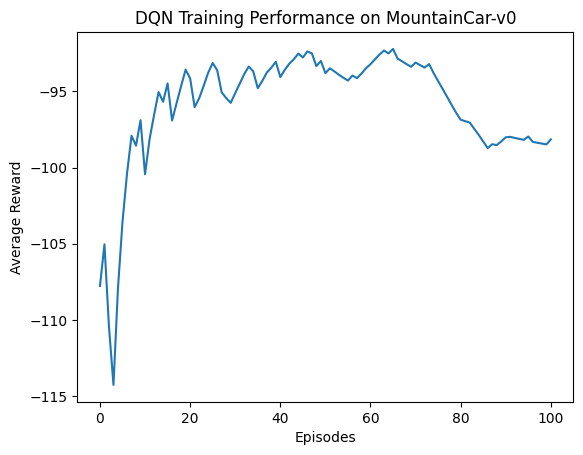

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 24)                  │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 3)                   │              75 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,243 (8.77 KB)

 Trainable params: 747 (2.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,496 (5.85 KB)

In [ ]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

SEED = 40
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 1000
THRESHOLD = -110
BATCH_SIZE = 64

class DQN:
    def __init__(self, env_string, batch_size=BATCH_SIZE):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.alpha = 0.01

        self.model = Sequential()
        self.model.add(Dense(24, input_dim=input_size, activation='relu'))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(action_size, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=self.alpha))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def preprocess_state(self, state):
        return np.reshape(state, [1, self.env.observation_space.shape[0]])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                reward = next_state[0][0]
                if done and next_state[0][0] >= 0.5:
                  reward = 100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i+= reward
            scores.append(i)
            avg_score = np.mean(scores)
            avg_scores.append(avg_score)

            if avg_score >= THRESHOLD and e >= 100:
                print("Ran {} episodes. Solved after {} trials".format(e, e))
                return avg_scores

            if e % 20 == 0:
                print("[Episode {}] - Mean survival time over last 100 episodes: {} ticks.".format(e, avg_score))
                print("Episode {}: Total Reward = {}".format(e, i))

            self.replay()

        print('Did not solve after {} episodes'.format(e))
        return avg_score

env_string = "MountainCar-v0"
agent = DQN(env_string)
avg_scores = agent.train()

plt.plot(avg_scores)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('DQN Training Performance on MountainCar-v0')
plt.show()

agent.model.summary()
